In [1]:
#Notebook's settings
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

#from jupyterthemes import jtplot
#jtplot.reset()

# Plotting

import sys
Folder='/Users/egordanilov/Desktop/Lesta_shared/GRF_strong_lensing/jax-strong-lensing/'
sys.path.append(Folder)

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from skimage import measure
#%matplotlib inline


# Basic imports
import numpy as np
from copy import deepcopy
import pandas as pd
from tqdm import tqdm
import math
import time

#JAX
import jax
import jax.numpy as jnp
from jax.config import config
config.update("jax_enable_x64", True)
config.update("jax_debug_nans", True)

from GRF_perturbations.Modules.Data_generation import Observation_conditions_class,generate_data
from GRF_perturbations.Modules.Image_processing import scipy_fit_image,compute_radial_spectrum,Radial_profile
from GRF_perturbations.Modules.Jax_Utils import purify_function,jax_map
from GRF_perturbations.Modules.Inference import distribution_Noise_LogSpectrum,compute_SNR_grid,Inference_pipeline,plot_likelihood,infer_LogNorm_params,compute_Loss_grid,Spectra_Loss,compute_Confidence_grid


#Fontsize
FS=18

/usr/local/Caskroom/miniforge/base/envs/env_jax/lib/python3.8/site-packages/jax/_src/lib/__init__.py:31: UserWarning: JAX on Mac ARM machines is experimental and minimally tested. Please see https://github.com/google/jax/issues/5501 in the event of problems.
  warnings.warn("JAX on Mac ARM machines is experimental and minimally tested. "


In [2]:
pixel_number=100
pixel_scale=0.08

PSF_FWHM=0.1 #arcsec, PSF of HST
exposure_time=2028 #COSMOS exposure
SNR=200 #75th percentile of COSMOS gaussian noise distribution 

Observation_conditions=Observation_conditions_class(pixel_number,pixel_scale,PSF_FWHM,SNR,exposure_time)

get_GRF=Observation_conditions.GRF_getter
simulate_perturbed_image=Observation_conditions.perturbed_image_getter
simulate_unperturbed_image=Observation_conditions.unperturbed_image_getter
simulate_unperturbed_image_pure=lambda kwargs: simulate_unperturbed_image(kwargs,Noise_flag=False)
compute_radial_spectrum_pure=purify_function(compute_radial_spectrum,Observation_conditions.annulus_mask,Observation_conditions.init_freq_index)

noise_var=Observation_conditions.noise_var
parameters=Observation_conditions.parameters
Estimated_Noise_spectral_density=(noise_var*Observation_conditions.annulus_mask).sum()/Observation_conditions.annulus_mask.sum()

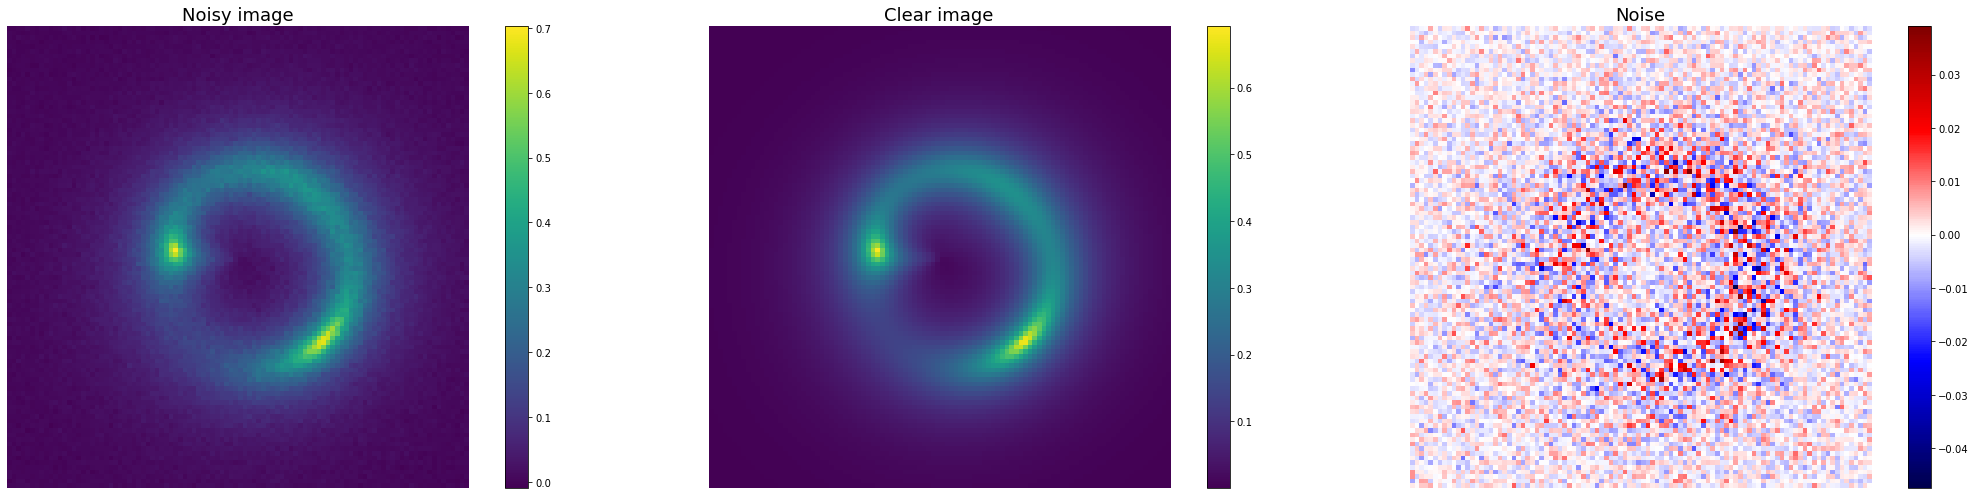

In [3]:
simulate_unperturbed_image=Observation_conditions.unperturbed_image_getter
Image_unperturbed_noiseless=simulate_unperturbed_image(Observation_conditions.kwargs_data,Noise_flag=False)
Image_unperturbed_noisy=simulate_unperturbed_image(Observation_conditions.kwargs_data,Noise_flag=True,noise_seed=42)

fig,ax=plt.subplots(1,3,figsize=(30,7))

img_arr=[]

img_arr+=[ax[0].imshow(Image_unperturbed_noisy)]
img_arr+=[ax[1].imshow(Image_unperturbed_noiseless)]
img_arr+=[ax[2].imshow(Image_unperturbed_noisy-Image_unperturbed_noiseless,cmap='seismic',norm=mpl.colors.TwoSlopeNorm(0))]

titles=['Noisy image','Clear image','Noise']

for i,axis in enumerate(ax):
    axis.set_title(titles[i],fontsize=FS)
    axis.axis('off')
    fig.colorbar(img_arr[i],ax=axis)

plt.tight_layout()
plt.show()

In [4]:
get_GRF=Observation_conditions.GRF_getter
extent = Observation_conditions.pixel_grid.extent

# GRF generation

In [5]:
from GRF_perturbations.Modules.GRF_generation import *

In [6]:
kgrid,dx=get_k_grid_dx(Observation_conditions.pixel_number,Observation_conditions.pixel_scale)
freqs=np.fft.fftshift(np.fft.fftfreq(Observation_conditions.pixel_number,Observation_conditions.pixel_scale))[Observation_conditions.pixel_number//2:]
def power_spectrum(GRF_params,kgrid):
    return np.where(kgrid!=0,np.power(10.,GRF_params[0])*np.power(kgrid,-GRF_params[1]),0)

In [7]:
k_grid,dx=get_k_grid_dx(Observation_conditions.pixel_number,Observation_conditions.pixel_scale)

GRF_params=[-7,2.]
field=get_GRF(GRF_params,1)
PS=power_spectrum(GRF_params,k_grid)

/var/folders/b3/rq1fyqk54w16ckpbh3g_g7tc0000gn/T/ipykernel_31046/3547858037.py:4: RuntimeWarning: divide by zero encountered in power
  return np.where(kgrid!=0,np.power(10.,GRF_params[0])*np.power(kgrid,-GRF_params[1]),0)


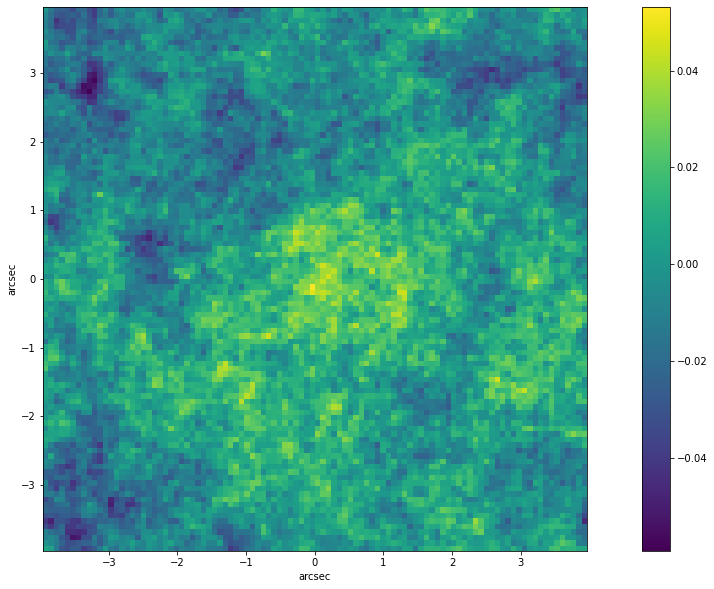

In [8]:
plt.figure(figsize=(20,10))
plt.imshow(field,extent=extent)

#plt.hlines(-1.2,-3,0,colors='w')
#plt.hlines(-2.5,-3,0,colors='w')

plt.xlabel('arcsec')
plt.ylabel('arcsec')
plt.colorbar()

In [9]:
GRF_params=[-7,2.]
field=get_jaxified_GRF(GRF_params,1,100,0.08)
PS=power_spectrum(GRF_params,k_grid)

/var/folders/b3/rq1fyqk54w16ckpbh3g_g7tc0000gn/T/ipykernel_31046/3547858037.py:4: RuntimeWarning: divide by zero encountered in power
  return np.where(kgrid!=0,np.power(10.,GRF_params[0])*np.power(kgrid,-GRF_params[1]),0)


In [10]:
field.var()

DeviceArray(0.0002254, dtype=float64)

In [11]:
PS.sum()

0.00017827785140093553

In [12]:
betas=np.linspace(0.1,5,100)
variances=np.zeros((100,100))
total_power=np.zeros((100))

for i,beta in tqdm(enumerate(betas)):
    total_power[i]=power_spectrum([-7,beta],k_grid).sum()
    for j in range(100):
        variances[i,j]=get_GRF([-7,beta],j).std()**2
        

0it [00:00, ?it/s]/var/folders/b3/rq1fyqk54w16ckpbh3g_g7tc0000gn/T/ipykernel_31046/3547858037.py:4: RuntimeWarning: divide by zero encountered in power
  return np.where(kgrid!=0,np.power(10.,GRF_params[0])*np.power(kgrid,-GRF_params[1]),0)
100it [00:30,  3.32it/s]


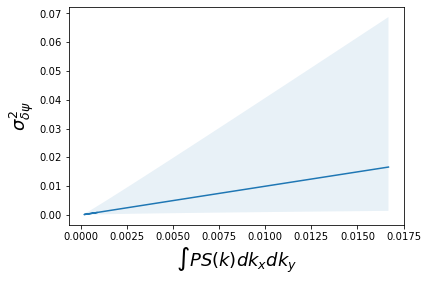

Linear approximation of mean  [1.00059489e+00 4.49135297e-06]


In [21]:
plt.plot(total_power,variances.mean(axis=-1))
plt.fill_between(total_power,variances.min(axis=-1),variances.max(axis=-1),alpha=0.1)
plt.xlabel(r'$\int PS(k)dk_xdk_y$',fontsize=FS)
plt.ylabel(r'$\sigma_{\delta \psi}^2$',fontsize=FS)
plt.show()
from scipy.optimize import curve_fit
popt,_=curve_fit(lambda power,k,b: k*power+b,total_power,variances.mean(axis=-1))
print('Linear approximation of mean ',popt)

Text(0, 0.5, '$\\sigma_{\\delta \\psi}^2-\\int PS(k)dk_xdk_y$')

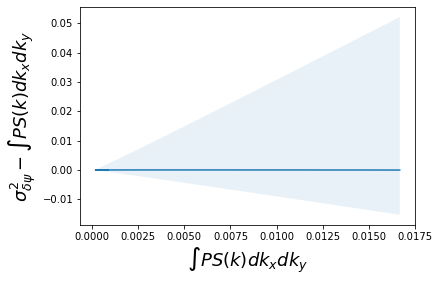

In [24]:
plt.plot(total_power,variances.mean(axis=-1)-total_power)
plt.fill_between(total_power,variances.min(axis=-1)-total_power,variances.max(axis=-1)-total_power,alpha=0.1)
plt.xlabel(r'$\int PS(k)dk_xdk_y$',fontsize=FS)
plt.ylabel(r'$\sigma_{\delta \psi}^2-\int PS(k)dk_xdk_y$',fontsize=FS)

Quite big phase variance though, but mean is close to the truth

Text(0.5, 0, '$\\sigma_{\\delta \\psi}^2$')

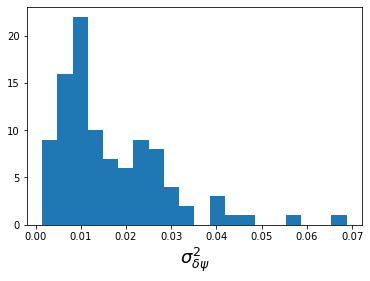

In [25]:
plt.hist(variances[-1],bins=20)
plt.xlabel(r'$\sigma_{\delta \psi}^2$',fontsize=FS)

# GRF power slope

The idea is to find such a frequency $\mathit{\widetilde{k}}$ that

$\int PS(k) dk_x dk_y = PS(\widetilde{k}) \int dk_x dk_y $

$\widetilde{\lambda}=\frac{1}{\widetilde{k}}=\left(\frac{\sum_{k_x} \sum_{k_y} k^{-\beta}}{N^2}\right)^{\frac{1}{\beta}}$


The constraint will be $\widetilde{\lambda}<\theta_{E}$,  
where $\theta_{E}$ is the Einstein radius of the unperturbed lens

logVar -8.40
log Spectral energy -8.63


/var/folders/b3/rq1fyqk54w16ckpbh3g_g7tc0000gn/T/ipykernel_31046/3547858037.py:4: RuntimeWarning: divide by zero encountered in power
  return np.where(kgrid!=0,np.power(10.,GRF_params[0])*np.power(kgrid,-GRF_params[1]),0)


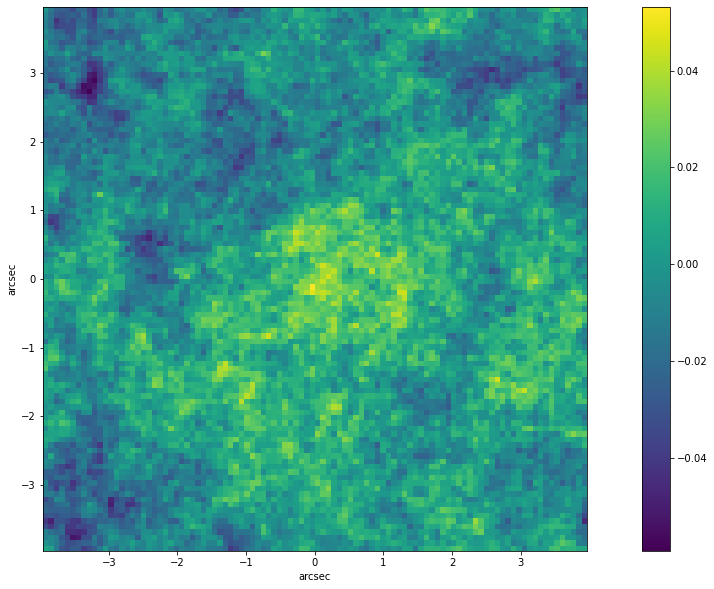

In [123]:
GRF_params=[-7,2]
field=get_GRF(GRF_params,1)
PS=power_spectrum(GRF_params,k_grid)

print('logVar {:.2f}'.format(np.log(field.var())))
print('log Spectral energy {:.2f}'.format(np.log(PS.sum())))
#print('Predicted scale {:.2f} arcsec'.format(GRF_scale(GRF_params[1],kgrid)))

plt.figure(figsize=(20,10))
plt.imshow(field,extent=extent)


plt.xlabel('arcsec')
plt.ylabel('arcsec')
plt.colorbar()

In [33]:
reg_kgrid=deepcopy(kgrid)
reg_kgrid[50,50]=1
mask_center=np.ones_like(reg_kgrid)
mask_center[100//2,100//2]=0

## Analytic limits

In [106]:
@jax.jit
def get_true_scale(beta):
    power_array=jnp.power(reg_kgrid,-beta)*mask_center
    
    total_energy=power_array.sum()
    
    scale=jnp.power(total_energy/(100**2),1/beta)
    return scale

true_scale_laplacian=jax.grad(jax.grad(get_true_scale))

In [107]:
betas=np.linspace(0.1,6,90)
scales=np.zeros_like(betas)
laplacian_scales=np.zeros_like(betas)

for i,beta in enumerate(betas):
    scales[i]=get_true_scale(beta)
    
    laplacian_scales[i]=true_scale_laplacian(beta)

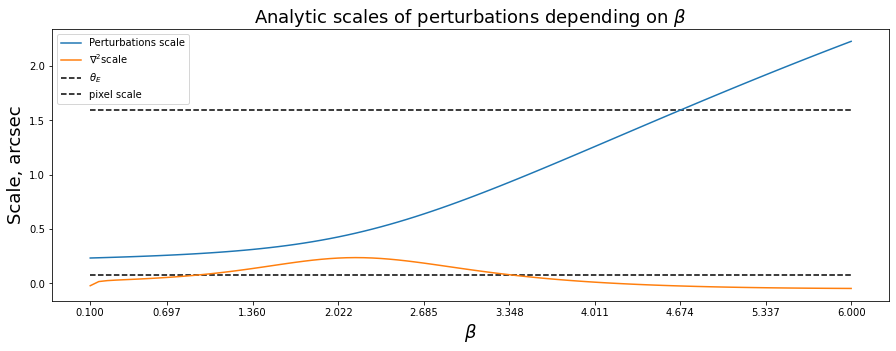

In [108]:
plt.figure(figsize=(15,5))
plt.plot(betas,scales,label='Perturbations scale')
plt.plot(betas,laplacian_scales,label=r'$\nabla^2$'+'scale')

upper_scale=Observation_conditions.kwargs_lens_mass[0]['theta_E']
lower_scale=Observation_conditions.pixel_scale

plt.hlines(upper_scale,betas[0],betas[-1],label=r'$\theta_{E}$',color='k',linestyle='--')
plt.hlines(lower_scale,betas[0],betas[-1],label='pixel scale',color='k',linestyle='--')


plt.legend()
xticks=betas[np.arange(9,90,10)]
plt.xticks(np.append([betas[0]],xticks))
plt.xlabel(r'$\beta$',fontsize=FS)
plt.ylabel('Scale, arcsec',fontsize=FS)

plt.title('Analytic scales of perturbations depending on '+r'$\beta$',fontsize=FS)
plt.show()

In [42]:
betas[np.argmin(np.abs(scales-upper_scale))]

4.7

$\beta$ limits: $\beta>0$ , $\lambda(\beta)<\theta_{E}$

## Data-driven limits

In [109]:
@jax.jit
def get_data_scale(beta,phase):
    
    Potential=get_GRF([0,beta],phase)
    total_energy=Potential.var()
    
    scale=jnp.power(total_energy/(100**2),1/beta)
    return scale

data_scale_laplacian=jax.grad(jax.grad(get_data_scale))

In [116]:
data_scales=np.zeros((len(betas),100))
data_laplacian_scales=np.zeros((len(betas),100))


for phi in tqdm(range(100)):
    scale_laplacian=jax.grad(jax.grad((lambda b: get_data_scale(b,phi+1))))
    for i,beta in enumerate(betas):
        data_scales[i,phi]=get_data_scale(beta,phi+1)
        data_laplacian_scales[i,phi]=scale_laplacian(beta)

100%|█████████████████████████████████████████| 100/100 [01:01<00:00,  1.64it/s]


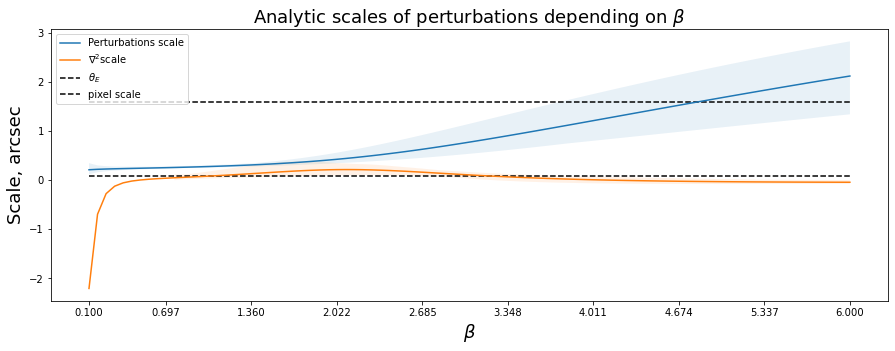

In [119]:
plt.figure(figsize=(15,5))
plt.plot(betas,data_scales.mean(axis=-1),label='Perturbations scale')
plt.fill_between(betas,data_scales.min(axis=-1),data_scales.max(axis=-1),alpha=0.1)

plt.plot(betas,data_laplacian_scales.mean(axis=-1),label=r'$\nabla^2$'+'scale')
plt.fill_between(betas[10:],data_laplacian_scales.min(axis=-1)[10:],data_laplacian_scales.max(axis=-1)[10:],alpha=0.1)

upper_scale=Observation_conditions.kwargs_lens_mass[0]['theta_E']
lower_scale=Observation_conditions.pixel_scale

plt.hlines(upper_scale,betas[0],betas[-1],label=r'$\theta_{E}$',color='k',linestyle='--')
plt.hlines(lower_scale,betas[0],betas[-1],label='pixel scale',color='k',linestyle='--')


plt.legend()
xticks=betas[np.arange(9,90,10)]
plt.xticks(np.append([betas[0]],xticks))
plt.xlabel(r'$\beta$',fontsize=FS)
plt.ylabel('Scale, arcsec',fontsize=FS)

plt.title('Analytic scales of perturbations depending on '+r'$\beta$',fontsize=FS)
plt.show()

In [120]:
betas[np.argmin(np.abs(data_scales.mean(axis=-1)-upper_scale))]

4.806741573033708

Data driven constraint almost correspond to the analytic one 

Let's say that 4.8 will be our limit

# GRF amplitude

The idea is to constriain GRF amplitude in terms of deflection

$A$ : $\delta \alpha (A_{min},0)=pix\_scl$ , $\delta \alpha (A_{max},4.5)=0.2 \times \theta_{E}$

## Data-driven constraints

In [146]:
xgrid,ygrid=Observation_conditions.pixel_grid.pixel_coordinates

betas=np.linspace(0,4.5,90)

'''
total_def_stds=np.zeros((90,100))
total_def_maxs=np.zeros((90,100))

for i,beta in tqdm(enumerate(betas)):
    for phi in range(100):
        alpha_x,alpha_y=Observation_conditions.LensImage_perturbed_noiseless.LensModel.alpha(xgrid,ygrid,[{},{},{'pixels':get_GRF([-7,beta],phi+1)}],k=2)
        total_def=np.sqrt(alpha_x**2+alpha_y**2)
        total_def_stds[i,phi]=total_def.std()
        total_def_maxs[i,phi]=total_def.max()
        
'''

90it [16:24, 10.94s/it]


In [151]:
#np.savez('data/deflection_stats',total_def_stds=total_def_stds,total_def_maxs=total_def_maxs)
arr=np.load('data/deflection_stats.npz')
total_def_stds=arr['total_def_stds']
total_def_maxs=arr['total_def_maxs']

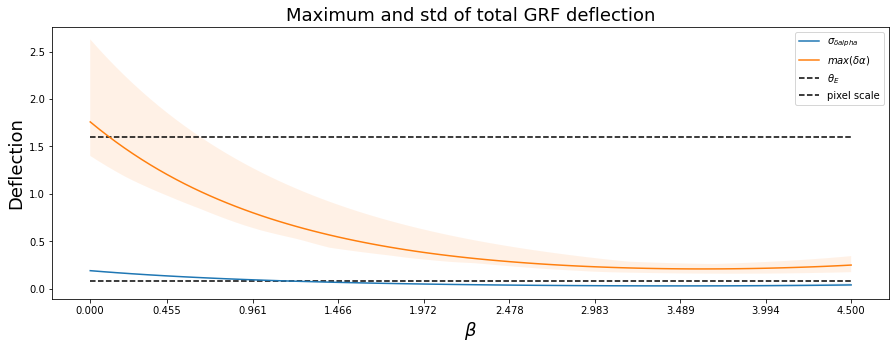

In [157]:
plt.figure(figsize=(15,5))
plt.plot(betas,total_def_stds.mean(axis=-1),label=r'$\sigma_{\delta alpha}$')
plt.fill_between(betas,total_def_stds.min(axis=-1),total_def_stds.max(axis=-1),alpha=0.1)

plt.plot(betas,total_def_maxs.mean(axis=-1),label=r'$max(\delta \alpha)$')
plt.fill_between(betas,total_def_maxs.min(axis=-1),total_def_maxs.max(axis=-1),alpha=0.1)

upper_scale=Observation_conditions.kwargs_lens_mass[0]['theta_E']
lower_scale=Observation_conditions.pixel_scale

plt.hlines(upper_scale,betas[0],betas[-1],label=r'$\theta_{E}$',color='k',linestyle='--')
plt.hlines(lower_scale,betas[0],betas[-1],label='pixel scale',color='k',linestyle='--')


plt.legend()
xticks=betas[np.arange(9,90,10)]
plt.xticks(np.append([betas[0]],xticks))
plt.xlabel(r'$\beta$',fontsize=FS)
plt.ylabel('Deflection',fontsize=FS)

plt.title('Maximum and std of total GRF deflection',fontsize=FS)

plt.show()

In [164]:
# deflection = 0.2 * theta_E
top_adjustment=0.2*Observation_conditions.kwargs_data['kwargs_lens'][0]['theta_E']/total_def_maxs.mean(axis=-1)[-1]
logA_top=np.log10(1e-7*top_adjustment**2)

In [165]:
# deflection = pixel_scale
bot_adjustment=pixel_scale/total_def_maxs.mean(axis=-1)[0]
logA_bot=np.log10(1e-7*bot_adjustment**2)

In [166]:
logA_top

-6.7904989669711195

In [167]:
logA_bot

-9.684313717027134

# Region borders

In [168]:
logA_borders=[-9.7,-6.8]
Beta_borders=[0,4.8]